# 5.6 Ensemble Methods

Suppose we have two prediction models $f_1$ and $f_2$. Can we combine the two models to produce an even better prediction model? Ensemble methods are ways of combining two or more prediction models.

First, let's fit two simple models (a linear regression model and a $50$-nearest neighbors model) so that we can combine them later.

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

housing_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
                         sep="\t")
X_train, y_train = housing_df[["Gr Liv Area"]].astype(float), housing_df["SalePrice"]

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model1 = LinearRegression()
model2 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=50))

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=50))])

The simplest way to combine 2 two prediction models is to take a weighted average 

$$ f({\bf x}) = \text{weight}_1 \cdot f_1({\bf x}) + \text{weight}_2 \cdot f_2({\bf x}) $$

or more generally, if we have $M$ models,

$$ f({\bf x}) = \text{weight}_1 \cdot f_1({\bf x}) + \text{weight}_2 \cdot f_2({\bf x}) + ... + \text{weight}_M \cdot f_M({\bf x}).$$

We could choose these weights arbitrarily. For example, in the absence of any information about the models, we should give equal weight to the predictions to each of the models, so one common choice for the weights is $1 / M$, in which case we simply average the predictions from the $M$ models.

So one way to combine predictions from the two models we fit above is to average them. For example, if we were trying to obtain predictions for a grid of $x$ values from 0 to 6000, we could do the following:

In [2]:
x_new = pd.Series(
    data=np.arange(6000.),
    index=np.arange(6000.)
)
X_new = x_new.to_frame()

(model1.predict(X_new) + model2.predict(X_new)) / 2

array([ 44099.81718238,  44155.66418281,  44211.51118324, ...,
       524325.91875449, 524381.76575492, 524437.61275535])

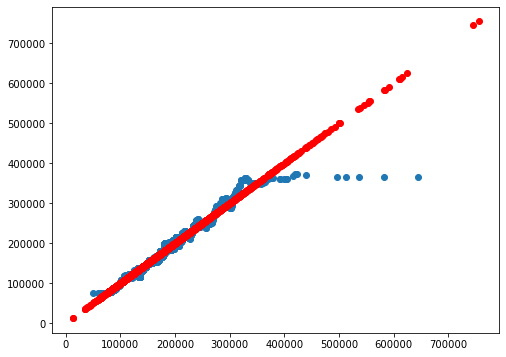

array([-4293.64021472, -6557.70086665,  -518.03849522, ...,
         957.81519683,  9001.10155624, -7809.88391964])

In [14]:
m1p = model1.predict(X_train)
m2p = model2.predict(X_train)

plt.figure(figsize=(8,6))

plt.scatter(x=m1p, y=m2p)
plt.scatter(x=y_train,y=y_train, c="red")
plt.show()

m1p - m2p

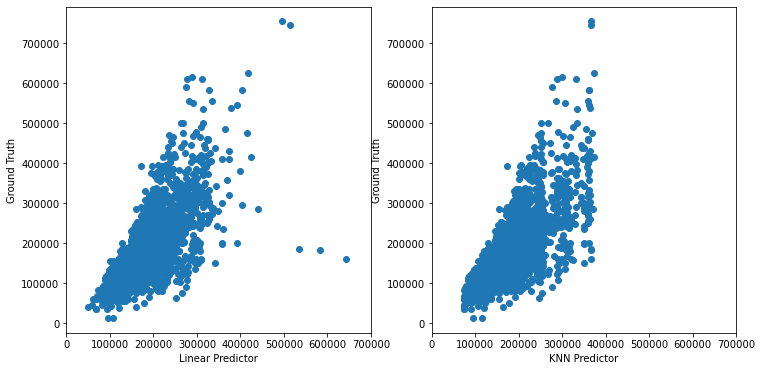

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x=m1p, y=y_train)
plt.xlabel("Linear Predictor")
plt.ylabel("Ground Truth")
plt.xlim(0,700000)
plt.subplot(122)
plt.scatter(x=m2p, y=y_train)
plt.xlabel("KNN Predictor")
plt.ylabel("Ground Truth")
plt.xlim(0,700000)
plt.show()


But we may be able to do better. We can learn the weights from data. Notice how the weights are essentially the "coefficients" in a linear regression model. We can calculate the predictions from each model on the training data and fit another linear regression model on top of these predictions to predict the label.

In [3]:
model_predictions = pd.DataFrame({
    "linear": model1.predict(X_train),
    "knn": model2.predict(X_train)
})

ensembler = LinearRegression(fit_intercept=False)
ensembler.fit(model_predictions, y_train)
ensembler.coef_

array([0.0721527 , 0.92908732])

So it appears that the optimal weights are $0.072$ and $0.929$. The $k$-nearest neighbors model gets much more weight than the linear regression model. Note that we did not constrain these weights to add up to 1, but it turns out that their sum comes out to be close to 1 anyway.

# Evaluating an Ensemble Model

How do we determine whether the ensemble model is better than the individual models? We use cross validation. But implementing $k$-fold cross validation is a bit tricky. For each fold, we need to refit each individual model in the ensemble, as well as the linear regression on top of the individual models' predictions. To do this, we will define a custom "model", or as _scikit-learn_ calls it, an "estimator". This estimator will carry out all of the steps in fitting an ensemble model and obtaining predictions from it.

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression

class RegressionEnsembler(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        # check that X and y have the correct shape
        X, y = check_X_y(X, y)
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # check that X has the right form
        X = check_array(X)
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        # return predictions
        if self.learn_weights:
            return self.ensembler.predict(Y_)
        else:
            return Y_.mean(axis=1)

Let's test out the `RegressionEnsembler` we just defined.

In [5]:
ensemble_model = RegressionEnsembler([model1, model2])

ensemble_model.fit(X_train, y_train)
ensemble_model.predict(X_train)

array([202489.90647013, 119600.7137348 , 162412.81411257, ...,
       120893.74835977, 160278.6520541 , 244227.18514808])

Now the `RegressionEnsembler` is something we can pass to `cross_val_score` to get validation errors.

In [6]:
from sklearn.model_selection import cross_val_score

(
    -cross_val_score(model1, X_train, y_train,
                     cv=20, scoring="neg_mean_squared_error").mean(),
    -cross_val_score(model2, X_train, y_train,
                     cv=20, scoring="neg_mean_squared_error").mean(),
    -cross_val_score(RegressionEnsembler([model1, model2], learn_weights=False), X_train, y_train,
                     cv=20, scoring="neg_mean_squared_error").mean(),
    -cross_val_score(RegressionEnsembler([model1, model2], learn_weights=True), X_train, y_train,
                     cv=20, scoring="neg_mean_squared_error").mean()
)

(3288114309.4176197,
 3274247814.1959844,
 3247240758.8164835,
 3316542363.5205145)

It appears that ensembling helps on this data set, but not if we try to learn the weights from the data. It is actually better to take a straight average than to try to learn the optimal weights.